In [1]:
#All necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC

In [2]:
df_model = pd.read_csv('fraud_model_data_new.csv',low_memory=False)
df_model

,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,DeductibleAmtPaid,Hospitalization_Duration,Inpatient_or_Outpatient,Gender,Race,...,State,County,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Patient_Age,isDead,PotentialFraud,TotalClaimAmount,TotalReimbursement,TotalDeductible
0,PRV57172,50,PHY383401,0,0,0,0,0,1,1,...,49,430,120,30,87,0,Yes,50,120,30
1,PRV57172,70,PHY370909,0,PHY363377,0,0,0,1,1,...,49,430,120,30,87,0,Yes,70,120,30
2,PRV55158,70,PHY383478,0,0,0,0,0,1,1,...,33,420,2530,540,86,0,No,70,2530,540
3,PRV54966,70,PHY347511,0,0,0,0,0,1,1,...,33,420,2530,540,86,0,Yes,70,2530,540
4,PRV54890,90,PHY343317,PHY408367,PHY408367,0,0,0,1,1,...,33,420,2530,540,86,0,No,90,2530,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV55826,80,PHY341548,0,0,0,0,0,2,1,...,29,150,1270,690,89,0,No,80,1270,690
558207,PRV54670,80,PHY351000,0,0,0,0,0,2,1,...,29,150,1270,690,89,0,No,80,1270,690
558208,PRV57336,30,PHY422310,PHY363262,0,0,0,0,2,1,...,29,150,1270,690,89,0,No,30,1270,690
558209,PRV51690,700,PHY379564,0,0,0,0,0,2,1,...,29,150,1270,690,89,0,No,700,1270,690


In [3]:
df_model.columns

Index(['Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'DeductibleAmtPaid',
       'Hospitalization_Duration', 'Inpatient_or_Outpatient', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Patient_Age', 'isDead', 'PotentialFraud',
       'TotalClaimAmount', 'TotalReimbursement', 'TotalDeductible'],
      dtype='object')

# XGBoost Classifier


Accuracy: 0.8001218168626784

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     69083
           1       0.73      0.76      0.74     42560

    accuracy                           0.80    111643
   macro avg       0.79      0.79      0.79    111643
weighted avg       0.80      0.80      0.80    111643



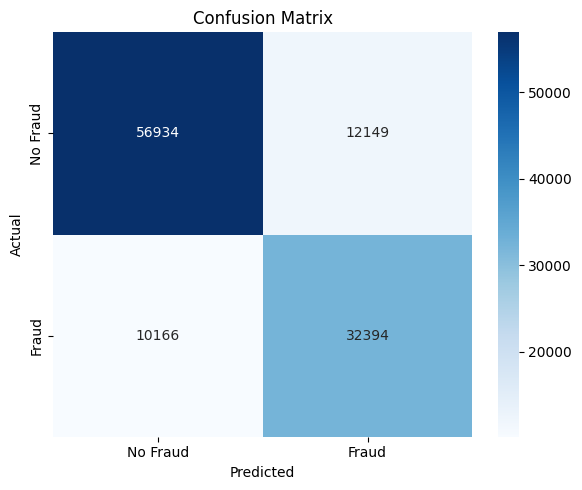


ROC AUC Score: 0.8734


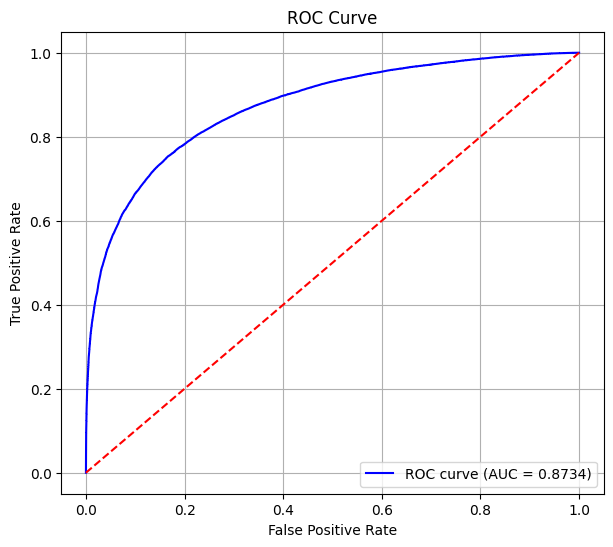

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# -------------------- Load and Prepare Data --------------------

# Assuming df_model is already defined with correct columns
df = df_model.copy()

# Target Mapping
df['PotentialFraud'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# -------------------- Feature Engineering --------------------

# Categorical Columns
categorical_cols = ['Inpatient_or_Outpatient', 'Gender', 'Race', 'RenalDiseaseIndicator',
                    'State', 'County', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# Numerical Columns
numerical_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Hospitalization_Duration',
                  'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age',
                  'TotalClaimAmount', 'TotalReimbursement', 'TotalDeductible', 'isDead']

# Encode categorical features
le = LabelEncoder()
for col in categorical_cols:
    df[col] = df[col].fillna("Missing")
    df[col] = le.fit_transform(df[col])

# Impute numerical features
imputer = SimpleImputer(strategy="mean")
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# -------------------- Model Training --------------------

# Features & target
X = df[categorical_cols + numerical_cols]
y = df['PotentialFraud']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Initialize and train XGBoost
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum()  # Handle class imbalance
)
model.fit(X_train, y_train)

# -------------------- Evaluation --------------------

y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities for the positive class (fraud=1)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest

Accuracy: 0.7484840070582124

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80     69083
           1       0.68      0.63      0.66     42560

    accuracy                           0.75    111643
   macro avg       0.73      0.73      0.73    111643
weighted avg       0.75      0.75      0.75    111643



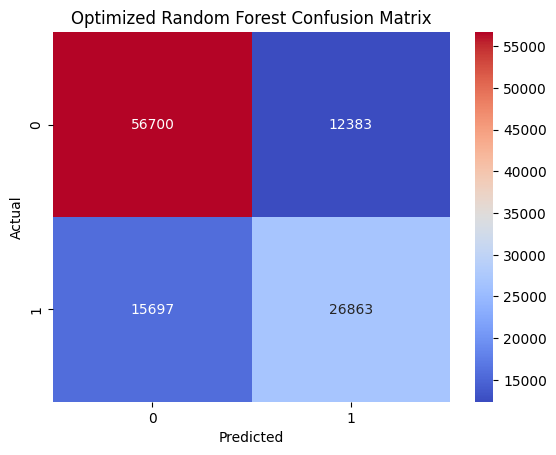


ROC AUC Score: 0.8106


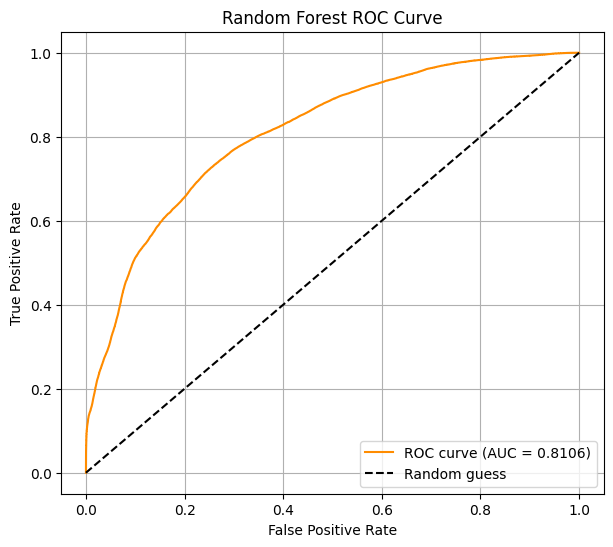

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Copy dataframe
df = df_model.copy()

# Define categorical and numerical columns
categorical_cols = ['Provider', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
                    'Inpatient_or_Outpatient', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County']

numerical_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Hospitalization_Duration',
                  'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age',
                  'TotalClaimAmount', 'TotalReimbursement', 'TotalDeductible', 'isDead']

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df[categorical_cols + numerical_cols]
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest
rf_fast = RandomForestClassifier(
    n_estimators=60,
    max_depth=10,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf_fast.fit(X_train, y_train)
y_pred = rf_fast.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title("Optimized Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC score and curve
y_proba = rf_fast.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# LightBGM

[LightGBM] [Info] Number of positive: 170236, number of negative: 276332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Accuracy: 0.8592298666284496

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     69083
           1       0.80      0.85      0.82     42560

    accuracy                           0.86    111643
   macro avg       0.85      0.86      0.85    111643
weighted avg       0.86      0.86      0.86    111643



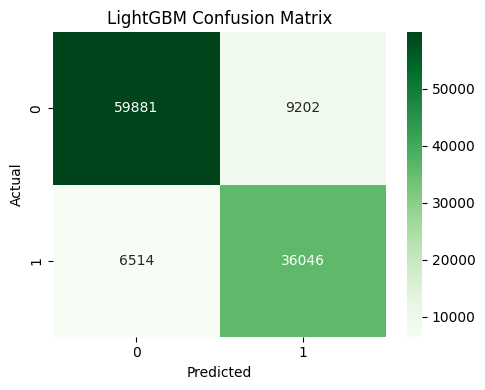

ROC AUC Score: 0.9304


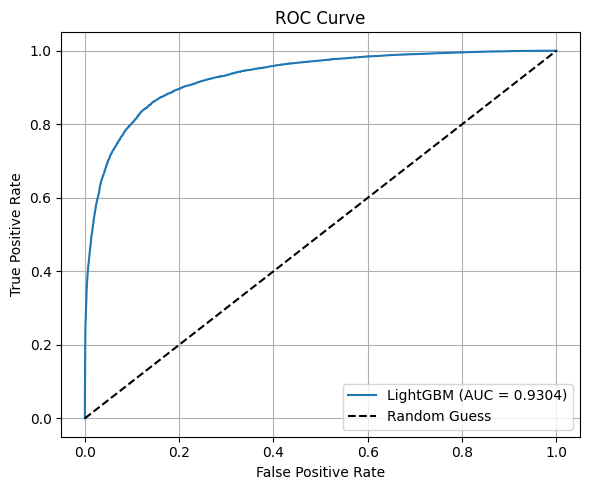

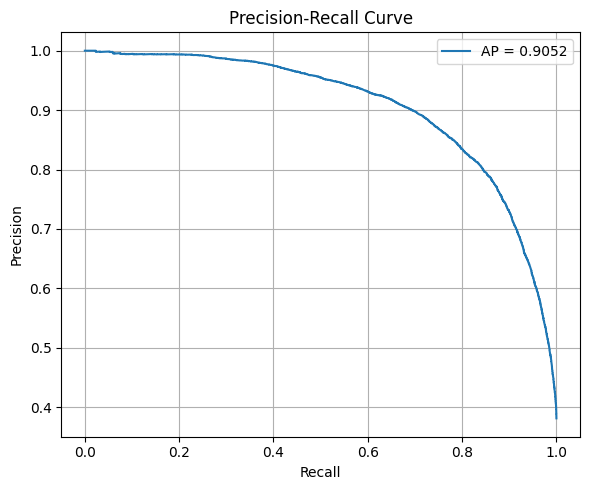

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgb_model.fit(X_train, y_train)

# Predict classes and probabilities on test set
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (fraud)

# Ensure y_test and y_pred are integers (0/1)
y_test_binary = pd.Series(y_test).astype(int)
y_pred_binary = pd.Series(y_pred).astype(int)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))

# Confusion Matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_binary, y_pred_binary), annot=True, fmt='d', cmap='Greens')
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve and Average Precision (AP)
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
avg_precision = average_precision_score(y_test_binary, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
X_test.head(5)

,Provider,AttendingPhysician,OperatingPhysician,OtherPhysician,Inpatient_or_Outpatient,Gender,Race,RenalDiseaseIndicator,State,County,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Patient_Age,TotalClaimAmount,TotalReimbursement,TotalDeductible,isDead
61016,3961,53749,0,0,0,0,0,1,50,0,100,0,0,750,640,107,100,750,640,0
353300,706,50881,0,0,0,0,0,0,25,29,30,90,0,200,160,86,120,200,160,0
249437,1465,5845,0,0,0,1,1,0,1,65,200,0,0,1390,150,84,200,1390,150,0
351077,2878,60751,7300,0,0,1,0,1,20,149,80,0,0,3530,770,70,80,3530,770,0
541709,5038,41899,0,113,0,0,0,0,43,23,500,0,0,1640,60,82,500,1640,60,0


In [8]:
y_test.head(5)

61016     1
353300    0
249437    0
351077    0
541709    1
Name: PotentialFraud, dtype: int64

# Trying ensemble Model

[LightGBM] [Info] Number of positive: 170236, number of negative: 276332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Ensemble Accuracy: 0.9017045403652715

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     69083
           1       0.90      0.84      0.87     42560

    accuracy                           0.90    111643
   macro avg       0.90      0.89      0.89    111643
weighted avg       0.90      0.90      0.90    111643



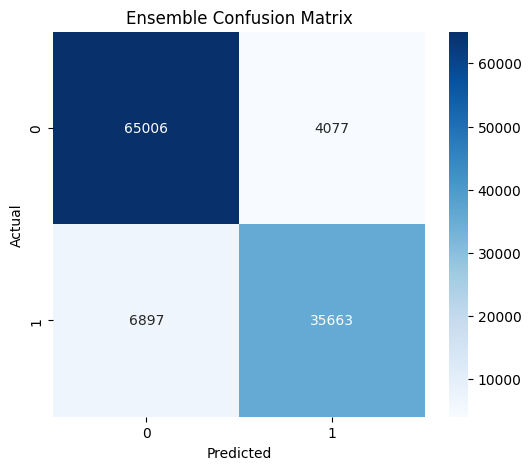

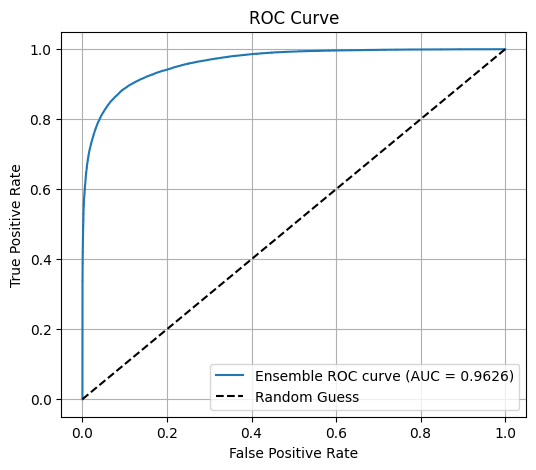

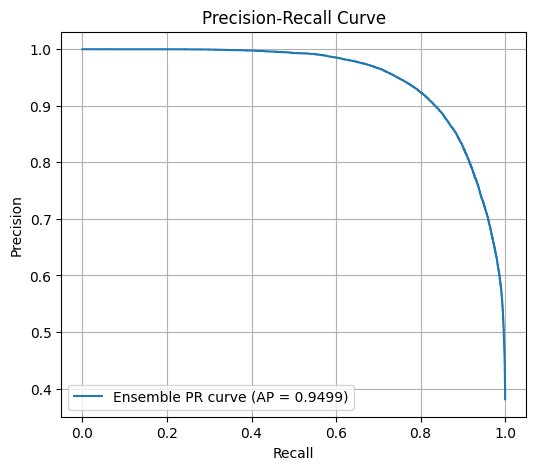

In [9]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming lgb_model is already defined as:
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=100)

# Define other models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create voting ensemble with soft voting
voting = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('rf', rf),
    ('xgb', xgb_model)
], voting='soft')

# Train ensemble
voting.fit(X_train, y_train)

# Predict classes and probabilities
ensemble_pred = voting.predict(X_test)
ensemble_proba = voting.predict_proba(X_test)[:, 1]  # Probability for class 1

# Convert y_test to binary 0/1 if not already
y_test_binary = y_test.map({'Yes': 1, 'No': 0}) if y_test.dtype == 'object' else y_test

# Accuracy and Classification report
print("Ensemble Accuracy:", accuracy_score(y_test_binary, ensemble_pred))
print("\nClassification Report:\n", classification_report(y_test_binary, ensemble_pred))

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_binary, ensemble_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('ensemble-confusion-matrix.png')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, ensemble_proba)
roc_auc = roc_auc_score(y_test_binary, ensemble_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Ensemble ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig('roc-curve.png')
plt.show()

# Precision-Recall Curve and Average Precision
precision, recall, _ = precision_recall_curve(y_test_binary, ensemble_proba)
avg_precision = average_precision_score(y_test_binary, ensemble_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'Ensemble PR curve (AP = {avg_precision:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.savefig('precision-recall-curve.png')
plt.legend()
plt.grid(True)
plt.show()


# Logistic Regression

Accuracy: 0.6108846949652016

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71     69083
           1       0.48      0.32      0.39     42560

    accuracy                           0.61    111643
   macro avg       0.57      0.56      0.55    111643
weighted avg       0.59      0.61      0.59    111643



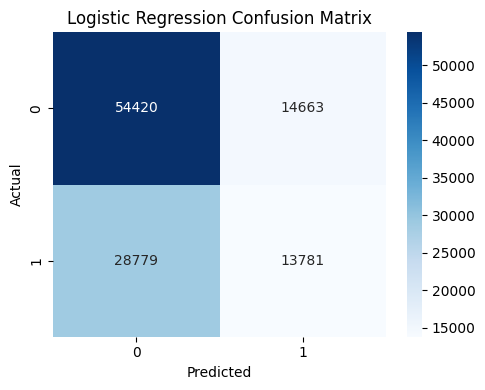

ROC AUC Score: 0.5876


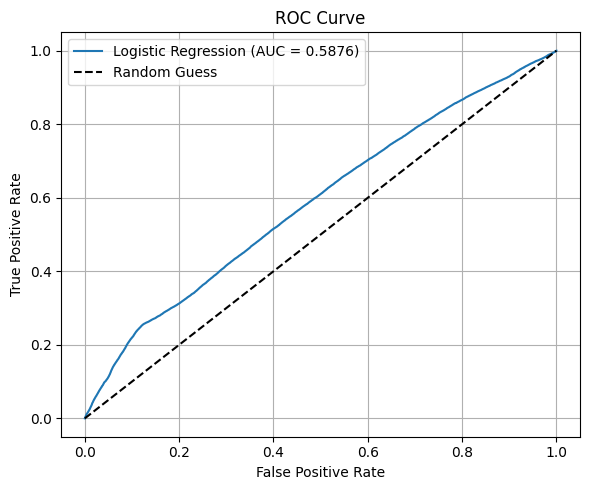

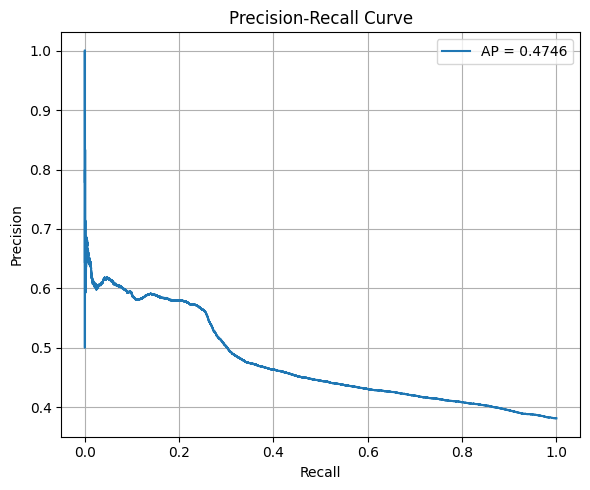

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed
# and y_test is binary (0/1)

# Initialize and train Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict labels and probabilities
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]  # Probability for class 1

# Convert y_test and y_pred to int if needed
y_test_binary = pd.Series(y_test).astype(int)
y_pred_binary = pd.Series(y_pred).astype(int)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))

# Confusion Matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_binary, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
avg_precision = average_precision_score(y_test_binary, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Decision Tree Classifier

Accuracy: 0.7986707630572449

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     69083
           1       0.70      0.83      0.76     42560

    accuracy                           0.80    111643
   macro avg       0.79      0.80      0.79    111643
weighted avg       0.81      0.80      0.80    111643



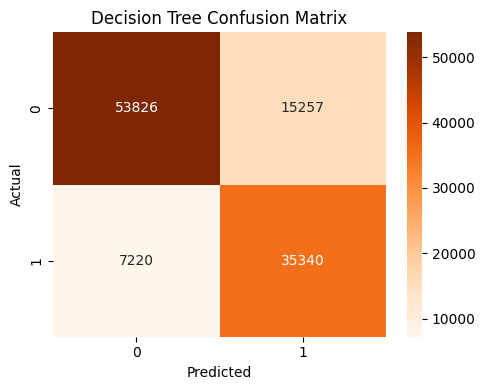

ROC AUC Score: 0.9006


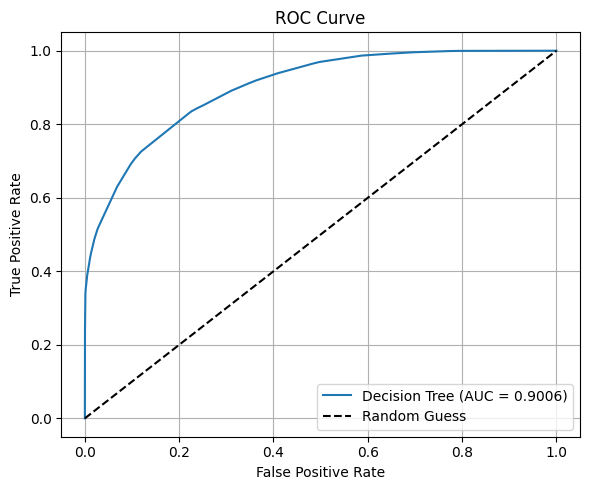

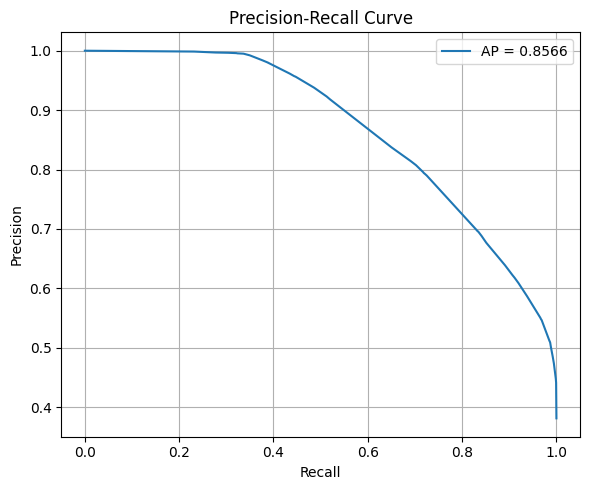

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_train, X_test, y_train, y_test are preprocessed and ready

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)

# Predictions and probabilities
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

# Convert to int series
y_test_binary = pd.Series(y_test).astype(int)
y_pred_binary = pd.Series(y_pred).astype(int)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))

# Confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_binary, y_pred_binary), annot=True, fmt='d', cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
avg_precision = average_precision_score(y_test_binary, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SHAP

Training voting ensemble...
[LightGBM] [Info] Number of positive: 170236, number of negative: 276332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Ensemble Accuracy: 0.9017045403652715

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     69083
           1       0.90      0.84      0.87     42560

    accuracy                           0.90    111643
   macro avg       0.90      0.89      0.89    111643
weighted avg       0.90      0.90      0.90    111643



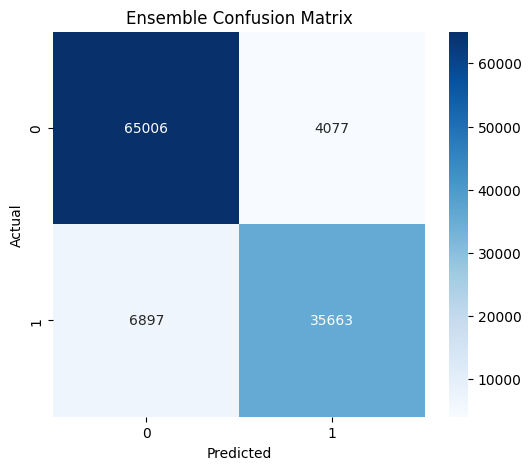

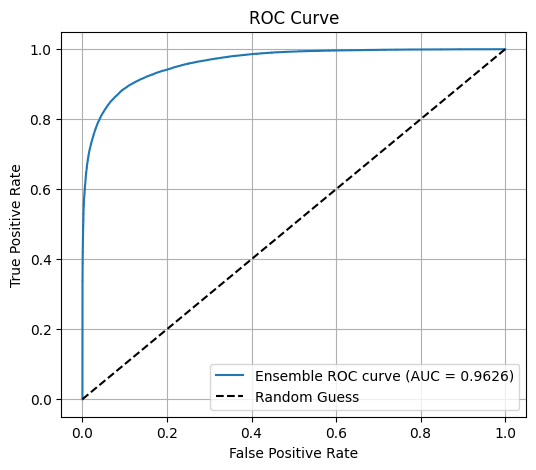

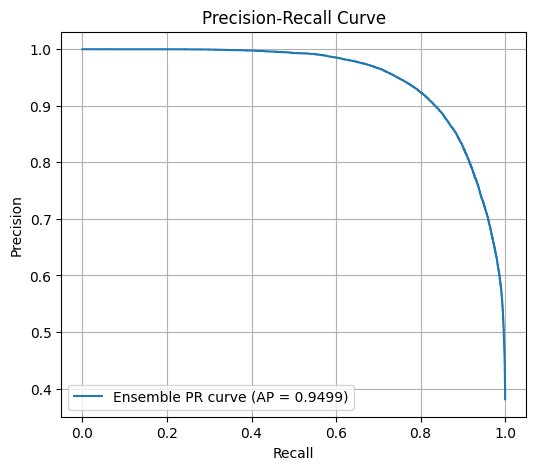


SHAP ANALYSIS


Extracting fitted LightGBM model from ensemble...
Creating TreeExplainer...
Calculating SHAP values for 100 test samples...
Binary classification detected. Using SHAP values directly.
Generating global feature importance plot...


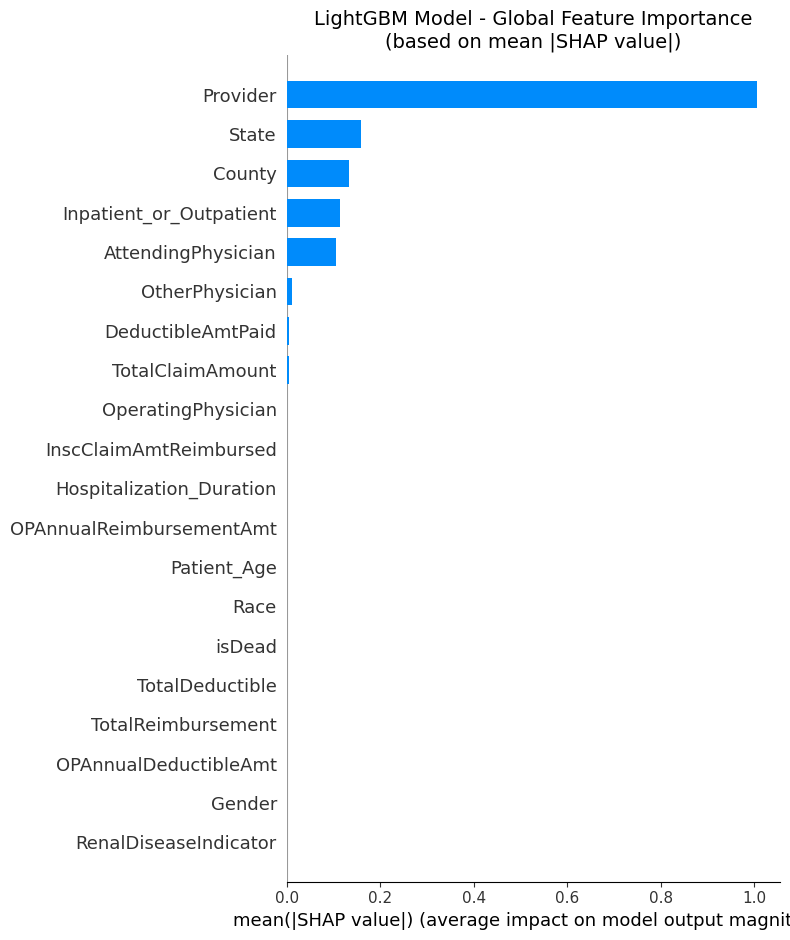

Generating detailed summary plot...


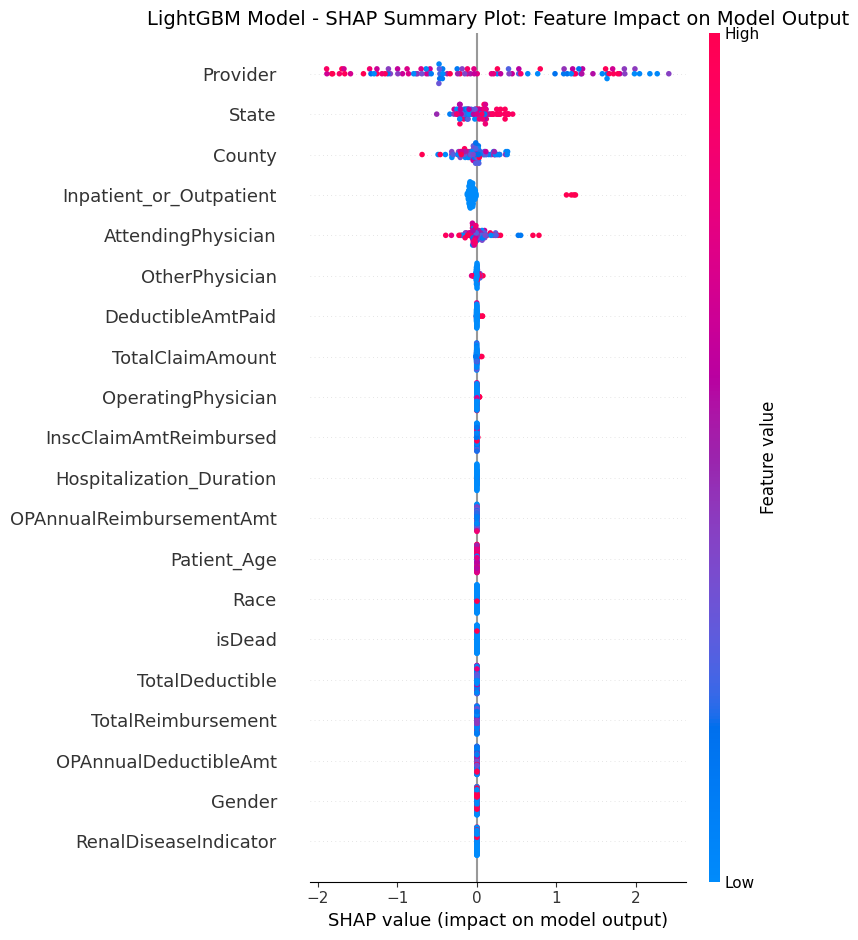

Generating force plot for a single prediction...


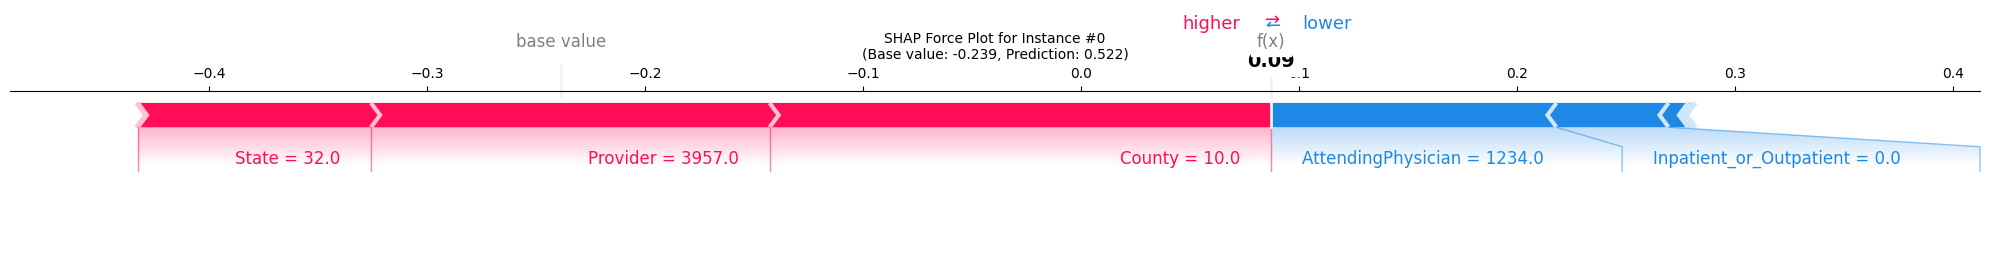

Generating dependence plot for the most important feature...


<Figure size 1000x600 with 0 Axes>

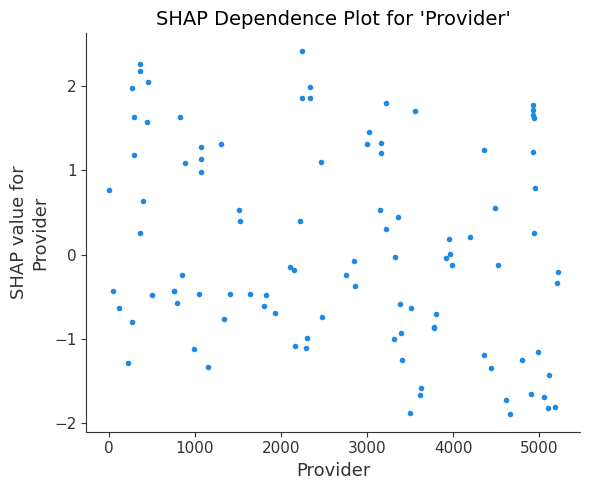

Generating waterfall plot...


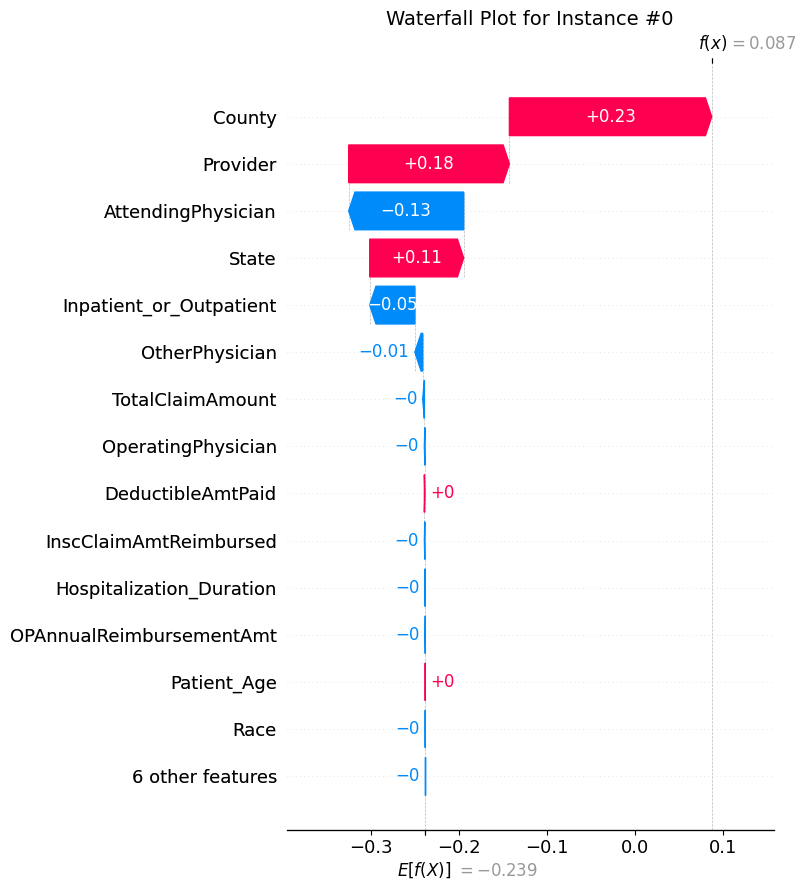


SHAP ANALYSIS COMPLETE
Generated the following files:
1. shap_global_importance.png - Overall feature importance
2. shap_detailed_summary.png - Detailed feature impact analysis
3. shap_force_plot_instance_0.png - Explanation for a single prediction
4. shap_dependence_plot_*.png - Relationship analysis for the most important feature
5. shap_waterfall_plot_instance_0.png - Alternative explanation format

Mean |SHAP| values for each feature (global importance):
                    feature  importance
0                  Provider    1.004395
8                     State    0.158066
9                    County    0.133507
4   Inpatient_or_Outpatient    0.113497
1        AttendingPhysician    0.105021
3            OtherPhysician    0.011635
11        DeductibleAmtPaid    0.004569
16         TotalClaimAmount    0.004389
2        OperatingPhysician    0.001869
10   InscClaimAmtReimbursed    0.000725


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Import SHAP library

# Load your dataset (replace 'your_data.csv' with your actual data file)
# df = pd.read_csv('your_data.csv')

# For this example, I'll assume you already have X_train, X_test, y_train, y_test defined
# If not, uncomment and adjust the following lines:

# # Separate features and target
# X = df.drop('target_column_name', axis=1)
# y = df['target_column_name']
#
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create voting ensemble with soft voting
voting = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('rf', rf),
    ('xgb', xgb_model)
], voting='soft')

# Train ensemble
print("Training voting ensemble...")
voting.fit(X_train, y_train)

# Predict classes and probabilities
ensemble_pred = voting.predict(X_test)
ensemble_proba = voting.predict_proba(X_test)[:, 1]  # Probability for class 1

# Convert y_test to binary 0/1 if not already
y_test_binary = y_test.map({'Yes': 1, 'No': 0}) if y_test.dtype == 'object' else y_test

# Accuracy and Classification report
print("\nEnsemble Accuracy:", accuracy_score(y_test_binary, ensemble_pred))
print("\nClassification Report:\n", classification_report(y_test_binary, ensemble_pred))

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_binary, ensemble_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('ensemble-confusion-matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, ensemble_proba)
roc_auc = roc_auc_score(y_test_binary, ensemble_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Ensemble ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig('roc-curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Precision-Recall Curve and Average Precision
precision, recall, _ = precision_recall_curve(y_test_binary, ensemble_proba)
avg_precision = average_precision_score(y_test_binary, ensemble_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'Ensemble PR curve (AP = {avg_precision:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.savefig('precision-recall-curve.png', dpi=150, bbox_inches='tight')
plt.show()

###############################################################################
# SHAP Analysis for Model Interpretation
###############################################################################
print("\n" + "="*60)
print("SHAP ANALYSIS")
print("="*60)

# Initialize JS for visualization (works in Jupyter notebooks)
shap.initjs()

# Extract the fitted LightGBM model from the trained ensemble
# This is the correct way to get a fitted individual model from the VotingClassifier
print("Extracting fitted LightGBM model from ensemble...")
fitted_lgb_model = voting.named_estimators_['lgb']

# Create TreeExplainer for the fitted LightGBM model
print("Creating TreeExplainer...")
explainer = shap.TreeExplainer(fitted_lgb_model)

# Calculate SHAP values for a sample of the test set (for efficiency)
sample_size = min(100, len(X_test))  # Use 100 or all samples if less than 100
print(f"Calculating SHAP values for {sample_size} test samples...")
X_test_sample = X_test.sample(sample_size, random_state=42) if len(X_test) > sample_size else X_test

shap_values = explainer.shap_values(X_test_sample)

# Handle the output format (LightGBM returns a list of arrays for multi-class)
if isinstance(shap_values, list):
    print("Multi-class classification detected. Using SHAP values for positive class (index 1).")
    shap_values_positive_class = shap_values[1]  # Use index 1 for class "1" in binary classification
else:
    print("Binary classification detected. Using SHAP values directly.")
    shap_values_positive_class = shap_values

# 1. Global Feature Importance Plot (Summary Plot - Bar)
print("Generating global feature importance plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive_class, X_test_sample, plot_type="bar", show=False)
plt.title("LightGBM Model - Global Feature Importance\n(based on mean |SHAP value|)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_global_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Detailed Summary Plot (Bee swarm plot)
print("Generating detailed summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive_class, X_test_sample, show=False)
plt.title("LightGBM Model - SHAP Summary Plot: Feature Impact on Model Output", fontsize=14)
plt.tight_layout()
plt.savefig('shap_detailed_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. Explain a Specific Individual Prediction
print("Generating force plot for a single prediction...")
instance_index = 0  # Explain the first instance in our sample

# Create force plot
shap.force_plot(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                shap_values_positive_class[instance_index, :],
                X_test_sample.iloc[instance_index, :],
                matplotlib=True,
                show=False)
plt.title(f"SHAP Force Plot for Instance #{instance_index}\n(Base value: {explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value:.3f}, Prediction: {fitted_lgb_model.predict_proba(X_test_sample.iloc[instance_index:instance_index+1])[0, 1]:.3f})", 
          fontsize=10)
plt.tight_layout()
plt.savefig(f'shap_force_plot_instance_{instance_index}.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Dependence Plot for the most important feature
print("Generating dependence plot for the most important feature...")
mean_abs_shap = np.abs(shap_values_positive_class).mean(0)
most_important_feature_index = np.argmax(mean_abs_shap)
most_important_feature_name = X_test.columns[most_important_feature_index]

plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature_name,
                     shap_values_positive_class,
                     X_test_sample,
                     interaction_index=None,
                     show=False)
plt.title(f"SHAP Dependence Plot for '{most_important_feature_name}'", fontsize=14)
plt.tight_layout()
plt.savefig(f'shap_dependence_plot_{most_important_feature_name}.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Waterfall plot for the same instance (alternative to force plot)
print("Generating waterfall plot...")
plt.figure(figsize=(12, 8))
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                                      shap_values_positive_class[instance_index, :],
                                      feature_names=X_test.columns,
                                      max_display=15,
                                      show=False)
plt.title(f"Waterfall Plot for Instance #{instance_index}", fontsize=14)
plt.tight_layout()
plt.savefig(f'shap_waterfall_plot_instance_{instance_index}.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SHAP ANALYSIS COMPLETE")
print("="*60)
print("Generated the following files:")
print("1. shap_global_importance.png - Overall feature importance")
print("2. shap_detailed_summary.png - Detailed feature impact analysis")
print("3. shap_force_plot_instance_0.png - Explanation for a single prediction")
print("4. shap_dependence_plot_*.png - Relationship analysis for the most important feature")
print("5. shap_waterfall_plot_instance_0.png - Alternative explanation format")
print("="*60)

# Optional: Print mean SHAP values for each feature (numeric importance)
print("\nMean |SHAP| values for each feature (global importance):")
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values_positive_class).mean(0)
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(10))  # Show top 10 most important features